# MLWare'24 
# Object Character Recognition using TrOCR

In [1]:
!pip install -q transformers
!pip install -q datasets jiwer

In [3]:
import pandas as pd

In [6]:
train_labels_df = pd.read_csv('/kaggle/input/mlwwww/train-labels_mlware.csv')

In [7]:
train_labels_df=train_labels_df.drop(columns=['Unnamed: 0'])

## Dataset and Train-Test Split

In [8]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['image'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + "/" + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [9]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(train_labels_df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

## Model

In [11]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
train_dataset = IAMDataset(root_dir='/kaggle/input/mlwwww/train_images_mlware/train_images',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/kaggle/input/mlwwww/train_images_mlware/train_images',
                           df=test_df,
                           processor=processor)

2024-03-16 07:48:51.381021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 07:48:51.381128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 07:48:51.517116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [12]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 20000
Number of validation examples: 5000


In [13]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


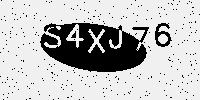

In [14]:
image = Image.open(train_dataset.root_dir + "/" + train_df['image'][0]).convert("RGB")
image

In [15]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

S4XJ76


In [16]:
#trocr-base-printed model is being utilised for fine tuning
from transformers import VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [17]:
# model configs
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

## Training

In [18]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch", 
    per_device_train_batch_size=4, 
    per_device_eval_batch_size=4, 
    fp16=True, 
    output_dir="./",
    logging_steps=10,
    save_steps=5000,  
    eval_steps=500,  
    num_train_epochs=6  
)

In [19]:
from datasets import load_metric
cer_metric = load_metric("cer")

In [20]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    return {"cer": cer}

In [ ]:
from transformers import default_data_collator

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Cer
1,0.260000,0.262227,0.037333
2,0.141500,0.147858,0.014500
3,0.058200,0.116781,0.007933
4,0.060100,0.134317,0.009033
5,0.005500,0.073331,0.001333


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1339: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Removed shared tensor {'decoder.output_projection.weight'} while saving. This should be OK, but check by verifying tha

In [25]:
model

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

## Inference

In [26]:
s=[]

In [27]:
test_dataset_path = "/kaggle/input/mlwwww/test_images_mlware/test_images/"

predictions = []

for i in range(5000):
    image_path = test_dataset_path + f"test-{i}.png"
    
    # Preprocess the image
    image = Image.open(image_path)
    inputs = processor(image, return_tensors="pt").pixel_values.to('cuda')
        with torch.no_grad():
        outputs = model.generate(inputs)

    generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0]
    s.append(generated_text)
    print(generated_text) 

7BZDKT
H3MBG5
Z3Q2WD
DBVSDF
EJBW89
MTAF6W
Y9Z5JG
FZV6MK
CHPZK2
PXHBBQ
SYBTJA
PWVNGZ
JUVK35
9H7GUB
SW5FBT
8UD3Z8
34NXUC
HJUEA6
Q2PHGJ
HFDWFW
MUEPTM
P2A67K
CXSDE4
C78VM5
K7PE78
RRAD8E
Q3334D
E49E2M
46HJV4
7AAJ6M
JGQPQ6
3RBP7A
V5U2Q6
MFY8FH
P6JV3U
44CD7A
FAAXB7
QQFRHD
WW43YH
DSQGHX
2ECXGM
VJJ4D9
992R6J
HBCZ8S
9Y86PH
W232YN
6DJ6NS
PSW3M3
NA5T9V
VA7S3B
V553GK
SSUBXQ
6GUTGF
YCMZRB
8ENCN2
8ZN98Q
MHNPAV
MKV6CC
QJS96B
T9VAPS
J6PA6K
F2FCH9
H7X9PP
XGUKTY
CFMF34
HD7Y6Z
CVMTTD
EE87CU
8D63GM
662QB9
6KEP6T
HYQRW4
PFGKNF
NGHGWJ
4JYQ8C
7APSA9
NTYXGZ
DW2J7G
AJM7WN
VE4NJD
E5FBPH
6SWEKX
M9566C
JAN5VG
PUX6DX
T8XT8G
2MGDAY
GN3R5D
QQJY4U
QD82VE
J6JZHA
3TZ4N6
MY7EWP
WW2NTQ
E8AY87
6RA8UX
QQ72EN
CE569Y
3G96Y2
477PK2
GR8DT2
DTRD4D
B7BK7J
U2KCCP
DGMECA
VHFB5Q
SGS8JT
BSGMD7
YT4KUW
EF94PG
QM2DUW
H5NHBM
6W8R6E
423Q34
KYB8DN
X3BEVJ
XBV3R6
SHAHVS
WUZ67Z
TZWZHJ
JS82ND
PVK7M5
DYDXRM
ZZ82JK
SWSJNR
2HM5PX
437WFB
RVJGRF
MCZFMK
XJAJDV
ACZN4U
49R5YR
UQAEG7
P5XZ72
3P4U7H
U4JUT6
KF5WCC
CXGCNT
P93DYA
ZMRPB8
MCJFH4
XBBM72
D97WA3

In [28]:
torch.save(model, '/kaggle/working/model_trOCR.pt')

In [29]:
#Checking for any possible "bad" predicitions.
c=0
for i in s:
    if len(i)<6:
        c=c+1

In [30]:
c

1

In [32]:
import pandas as pd

# Assuming you have the list 's' containing all the predicted text values
# Create a DataFrame
df = pd.DataFrame({'ID': range(5000), 'text': s})

# Print the DataFrame
print(df)

        ID    text
0        0  7BZDKT
1        1  H3MBG5
2        2  Z3Q2WD
3        3  DBVSDF
4        4  EJBW89
...    ...     ...
4995  4995  9E73J3
4996  4996  N3WPBK
4997  4997  MRYY4T
4998  4998  MDCG6K
4999  4999  95QPRS

[5000 rows x 2 columns]


In [33]:
df.head()

,ID,text
0,0,7BZDKT
1,1,H3MBG5
2,2,Z3Q2WD
3,3,DBVSDF
4,4,EJBW89


In [34]:
df.to_csv("submit.csv")

In [35]:
import pandas as pd

In [36]:
vals = pd.read_csv("/kaggle/working/submit.csv")

In [37]:
vals.head()

,Unnamed: 0,ID,text
0,0,0,7BZDKT
1,1,1,H3MBG5
2,2,2,Z3Q2WD
3,3,3,DBVSDF
4,4,4,EJBW89


In [42]:
cnt=0
for i in range(5000):
    if(len(vals['text'][i])<6):
        cnt=cnt+1

In [44]:
cnt

1

In [41]:
var

303